In [1]:
import torch
from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from rdkit.Chem import Draw, PandasTools
from torch_geometric.loader import DataLoader
import torch
from modules.som_dataset import CustomDataset
from modules.som_models import GNNSOM
from utils import validation
import numpy as np
import warnings
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')
warnings.filterwarnings('ignore', '')

In [3]:
def CYP_REACTION(x):
    cyp_col = ['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4']
    cyp_reactions = x[cyp_col].tolist()
    cyp_reactions = [i for i in cyp_reactions if i] 
    return '\n'.join( cyp_reactions )

In [4]:
cyp_list = [f'BOM_{i}' for i in  '1A2 2A6 2B6 2C8 2C9 2C19 2D6 2E1 3A4'.split()] + ['CYP_REACTION']

In [13]:
class CONFIG:
    substrate_loss_weight = 0.33    
    bond_loss_weight = 0.33
    atom_loss_weight = 0.33
    pos_weight = torch.ones(10)
    som_type_loss_weight = 0.33
    class_type = 2    
    th = 0.1    
    substrate_th = 0.5
    adjust_substrate = False
    test_only_reaction_mol = False
    equivalent_bonds_mean = False
    average = 'binary'            
    device = 'cuda:0'    
    reduction = 'sum'
    metric_mode = 'bond'
    n_classes = 5
args = CONFIG()



In [14]:
model = GNNSOM(
            num_layers=2,
            gnn_num_layers = 8,
            pooling='sum',
            dropout=0.1, 
            cyp_list=cyp_list, 
            use_face = True, 
            node_attn = True,
            face_attn = True,            
            n_classes=args.n_classes,
            ).to('cuda:0')

In [15]:
test_df = PandasTools.LoadSDF('data/cyp_map_test.sdf')
test_df['CYP_REACTION'] = test_df.apply(CYP_REACTION, axis=1)
test_df['POS_ID'] = 'TEST' + test_df.index.astype(str).str.zfill(4)

test_dataset = CustomDataset(df=test_df, cyp_list=cyp_list, args=args)
test_loader = DataLoader(test_dataset, num_workers=2, batch_size=8, shuffle=False)

loss_fn_ce, loss_fn_bce = torch.nn.CrossEntropyLoss(), torch.nn.BCEWithLogitsLoss()

Processing...
Done!


In [16]:
args.ckpt = 'ckpt/0.pt' # best_model_ckpt.zip 파일 압축 풀어서 넣기
model.load_state_dict(torch.load(args.ckpt, 'cpu'))
test_scores = validation(model, test_loader, loss_fn_ce, loss_fn_bce, args)
validator = test_scores['validator'] 

In [17]:
print(validator.y_prob.keys())
print(validator.y_prob['bond_som'].keys())

dict_keys(['subs', 'bond_som', 'atom_som', 'atom_spn', 'oxc', 'oxi', 'epo', 'sut', 'dhy', 'hys', 'rdc'])
dict_keys(['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4', 'CYP_REACTION'])


In [18]:
y_bond_som_1A2 = np.array(validator.y_prob['bond_som']['BOM_1A2'])

(array([4357.,  207.,  136.,   45.,   58.,   43.,   20.,   20.,   37.,
          16.]),
 array([0.00118948, 0.08425088, 0.16731228, 0.25037369, 0.33343509,
        0.41649649, 0.49955789, 0.58261929, 0.6656807 , 0.7487421 ,
        0.8318035 ]),
 <BarContainer object of 10 artists>)

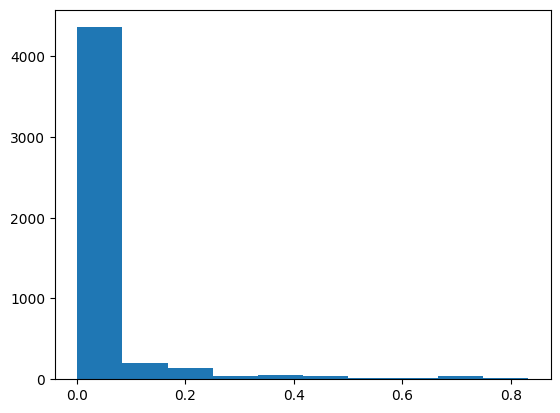

In [19]:
plt.hist(y_bond_som_1A2)